In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.cluster.hierarchy as hac

import pandas

import glob
import struct
from collections import Counter

# Расшифровка протокола VHome

In [235]:
# takes filename
# open file, read binary data
# returns numpy.array of impulses (positive integer)
# and pauses (negative integer)
def file_to_data(filename):
    pic = open(filename, "rb")
    data = []
    while True:
        buf = pic.read(4)
        if not buf or len(buf) != 4:
            break
        sign = 1 if buf[3] == 1 else -1
        buf = bytes(buf[:3] + bytes([0]))
        data.append(sign * struct.unpack('i', buf)[0])
    return np.array(data)

# takes files' mask
# returns numpy.array of data
def files_to_data(mask):
    # откуда брать дампы
    filenames = sorted(glob.glob(mask))
    
    print("%d files found" % len(filenames))

    datas = []

    # посмотрим файлики с дампами, преобразуем в импульсы
    for name in filenames:
        print("read " + name)
        datas.append(file_to_data(name))

    return np.concatenate(datas)


In [313]:
# читаем информацию
data = files_to_data("./*btn-*.rcf")

7 files found
read ./1btn-longpress1.rcf
read ./1btn-shortpress1.rcf
read ./2btn-longpress1.rcf
read ./2btn-longpress2.rcf
read ./3btn-longpress1.rcf
read ./3btn-longpress2.rcf
read ./3btn-longpress3.rcf


In [314]:
#print(list(data[40:]))

Посмотрим на гистограммы длин импульсов и пауз

In [315]:
# show histogramm of lengthes
# ignore lengthes that is greater than (1 - threshold) quantile
def show_hist(data, title, threshold=0.02):
    k = int(len(data) * (1 - threshold))
    data = np.partition(data, k)[:k]
    
    plt.hist(data, bins = 100)
    plt.title(title)
    plt.xlim([0, data.max() * 1.1])
    plt.show()

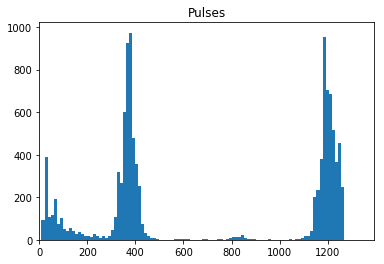

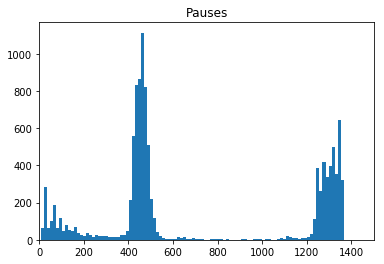

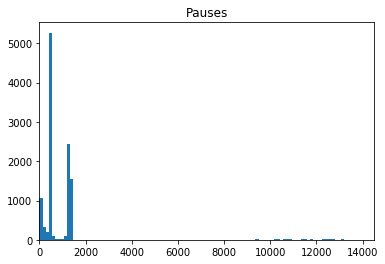

In [316]:
show_hist(data[data > 0], "Pulses", threshold=0.05)
show_hist(-data[data < 0], "Pauses", threshold=0.05)
show_hist(-data[data < 0], "Pauses", threshold=0.01) # обращаем внимание на непримечательный пик справа

Немножко удобной автоматики для группирования сигналов по длинам

In [317]:
# data - list of signals
# threshold - length of minimal distance between clusters
# threshold_count - minimal count of signals in group
# output format list of such structures 
# (letter, lower, upper, count) giving information about group
def clusterize_signals(data, threshold = 100, threshold_count = 10):
    groups = []

    for signals in (data[data > 0], data[data < 0]):
        # clasterization from scipy
        signals_color = hac.fclusterdata(X = np.matrix([signals]).T, 
                                  criterion='distance', t = threshold)
        for i in range(1, 10000):
            group = signals[signals_color == i]
            if (len(group) == 0):
                break
            bounds = (abs(int(group.mean())), group.min(), group.max(), len(group))
            if len(group) > threshold_count:
                groups.append(bounds)

    groups = sorted(groups)

    cur_impulse_code = ord('A')
    cur_pause_code = ord('a')

    for i in range(len(groups)):
        mean, lower, upper, count = groups[i]
        code = 0
        if (lower > 0):
            code = cur_impulse_code
            cur_impulse_code += 1
            groups[i] = (chr(code), 
                         max(1, int(lower - threshold / 3)), 
                         int(upper + threshold / 3), 
                         count)
        else:
            code = cur_pause_code
            cur_pause_code += 1
            groups[i] = (chr(code), 
                         int(lower - threshold / 3), 
                         min(int(upper + threshold / 3), -1), 
                         count)
    return groups

# делаем группы
groups = clusterize_signals(data, threshold = 10, threshold_count = 7)
print("(letter, lower, upper, count)")
print("\n".join(map(str, groups)))

(letter, lower, upper, count)
('A', 5, 519, 5973)
('a', -737, -3, 6978)
('b', -825, -783, 8)
('B', 774, 902, 92)
('c', -1042, -1013, 10)
('C', 1083, 1431, 5241)
('d', -1457, -1063, 4068)
('D', 1437, 1515, 24)
('E', 1580, 1617, 11)
('F', 1646, 1679, 8)
('G', 1766, 1820, 10)
('e', -13266, -13147, 117)


Получили группы сигналов
Много шумов, будем руками вводить

In [318]:
groups = [
    ('A', 1, 700, 3000),
    ('B', 1000, 1400, 1300),
    ('a', -800, -1, 3000),
    ('b', -1400, -800, 1300),
    ('c', -20000, -2000, 20)
]

In [319]:
# All the same but in a table
data_frame = pandas.DataFrame([(lower, upper, count) for letter, lower, upper, count in groups], 
                              index=[letter for letter, lower, upper, count in groups],
            
                              columns=['Lower length', 'Upper length', 'count of signals'])
data_frame.insert(1, "Type", ["impulse" if lower > 0 else "pause" for c, lower, upper, count in groups])
data_frame = data_frame.sort_index()
#data_frame = data_frame.pivot_table(index='Letter')
data_frame

,Lower length,Type,Upper length,count of signals
A,1,impulse,700,3000
B,1000,impulse,1400,1300
a,-800,pause,-1,3000
b,-1400,pause,-800,1300
c,-20000,pause,-2000,20


Заменим каждый сигнал буквой, обозначающей его группу. Так зачастую удобнее

In [320]:
# finds signal in groups
# returns a corresponding letter
def decode_signal(x, groups):
    for c, lower, upper, group in groups:
        if lower <= x <= upper:
            return c
    return "?"

# decode list of signals
# each signal is decoded separately
def decode_signals(data, groups):
    return [decode_signal(signal, groups) for signal in data]


# decoded signals
data_letters = decode_signals(data, groups)

data_letters = [c if c != "d" else 'c' for c in data_letters]

print("Decoded (characters): ", "".join(data_letters))
    

Decoded (characters):  c?bBaAbAbAbAbBaAbAbAbAbBaBaBaA?BaBaAbAbAbBaAbAcAaAaAcBaAbAbBaAbAbAbAbBaAbAbAbAbBaBaBaAbBaBaAbAbAbBaAbAcAaAa?aAbAbBaAbAbAbAbBaAbAbAbAbBaBaBaAbBaBaAbAbAbBaAbAcAaAaAaAaAaAaAa?aAbAbBaAbAbAbAbBaAbAbAbAbBaBaBaAbBaBaAbAbAbBaAbAcAaAaAaaaAa?aBaAbAbBaAbAbAbAbBaAbAbAbAbBaBaBaAbBaBaAbAbAbBaAbAcAaAaAaAaAaAa?aAbAbBaAbAbAbAbBaAbAbAbAbBaBaBaAbBaBaAbA?AbBaAbAcAaAaAaAaAaAaAa?aAbAbBaAbAbAbAbBaAbAbAbAbBaBaBaAbBaBaAbAbAbBaAbAcAaAaAaAaAaAaAa?aAbAbBaAbAbAbAbBaAbAbAbAbBaBaBaAbBaBaAbAbAbBaAbAcAaAaAaAaAaAa?aAbAbBaAbAbA?AbBaAbAbAbAbBaBaBaAbBaBaAbAbAbBaAbAcAaAaAaAaAaAaAaAa?aAbAbBaAbA?AbAbBaAbAbAbAbBaBaBaAbBaBaAbAbAbBaAbA?AaAaAaAaAaAa?aAbAbBaAbAbAbAbBaAbAbAbAbBaBaBaAbBaBaAbAbAbBaAbAcAaAaaaAaAa?aAbAbBaAbAbAbAbBaAbAbAbAbBaBaBaAbBaBaA?AbAbBaAbA?AaAaAaAaAaAaAaAa?aA?AbBaAbAbAbAbBaAbAbAbAbBaBaBaAbBaBaAbAbAbBaAbAcA?AaAaAaBaAbAbBaAbAbAbAbBaAbAbAbAbBaBaBaAbBaBaAbAbAbBaAbAcAbAaAaAa?aAbAbBaAbAbAbAbBaAbAbAbAbBaBaBaAbBaBaAbAbAbBaAbAcAaAaAaAaAaAaBaAbAbBaAbAbAbAbBaAbAbAbAbBaBaBaAbBaBaAbAbAbBaAbAcA?AaAaAaAa

Видим манхеттоновское шифрование (Ab, Ba)

In [321]:
medium1 = "".join(data_letters).replace('Ab', '0').replace('Ba', '1')

print(medium1)

c?b1000010000111A?1100010AcAaAaAc100100001000011101100010AcAaAa?a00100001000011101100010AcAaAaAaAaAaAaAa?a00100001000011101100010AcAaAaAaaaAa?a100100001000011101100010AcAaAaAaAaAaAa?a0010000100001110110A?010AcAaAaAaAaAaAaAa?a00100001000011101100010AcAaAaAaAaAaAaAa?a00100001000011101100010AcAaAaAaAaAaAa?a00100A?01000011101100010AcAaAaAaAaAaAaAaAa?a0010A?001000011101100010A?AaAaAaAaAaAa?a00100001000011101100010AcAaAaaaAaAa?a001000010000111011A?0010A?AaAaAaAaAaAaAaAa?aA?0100001000011101100010AcA?AaAaAa100100001000011101100010Ac0AaAaAa?a00100001000011101100010AcAaAaAaAaAaAa100100001000011101100010AcA?AaAaAaAaAa?a00100001000011101100010A?AaAaAaAa?a00100001000011101100010AcAaAaAa100100001000011101100010AcAaAa100100001000011101100010AcAaAaAaAaAa100100001000011101100010AcAa0AaAaAa100100001000011101100010Ac100100001000011101100010Ac100100001000011101100010AcAaAa100100001000011101100A?10Ac100100001000011101100010AcAaAa100100001000011101100010AcAA?a00100001000011101100010Ac1001000A?10000111011000

Ac - разделитель

In [322]:
print(medium1.split("Ac"))

['c?b1000010000111A?1100010', 'AaAa', '100100001000011101100010', 'AaAa?a00100001000011101100010', 'AaAaAaAaAaAaAa?a00100001000011101100010', 'AaAaAaaaAa?a100100001000011101100010', 'AaAaAaAaAaAa?a0010000100001110110A?010', 'AaAaAaAaAaAaAa?a00100001000011101100010', 'AaAaAaAaAaAaAa?a00100001000011101100010', 'AaAaAaAaAaAa?a00100A?01000011101100010', 'AaAaAaAaAaAaAaAa?a0010A?001000011101100010A?AaAaAaAaAaAa?a00100001000011101100010', 'AaAaaaAaAa?a001000010000111011A?0010A?AaAaAaAaAaAaAaAa?aA?0100001000011101100010', 'A?AaAaAa100100001000011101100010', '0AaAaAa?a00100001000011101100010', 'AaAaAaAaAaAa100100001000011101100010', 'A?AaAaAaAaAa?a00100001000011101100010A?AaAaAaAa?a00100001000011101100010', 'AaAaAa100100001000011101100010', 'AaAa100100001000011101100010', 'AaAaAaAaAa100100001000011101100010', 'Aa0AaAaAa100100001000011101100010', '100100001000011101100010', '100100001000011101100010', 'AaAa100100001000011101100A?10', '100100001000011101100010', 'AaAa100100001000011101100010', '

Видим, что часто идет 24 цифры в конце. Проверяем

In [323]:
packlen = 24
medium2 = [x for x in [y[-packlen:] for y in medium1.split("Ac") if len(y) >= packlen] 
           if x.find('?') == -1 and x.find('a') == -1]
Counter(medium2)

Counter({'011010110000111101100001': 48,
         '011010110000111101100100': 59,
         '100100001000011101100010': 36,
         '111111111100101101100001': 43,
         '111111111100101101100010': 17,
         '111111111100101101100100': 36})

Как раз 6 групп по количеству уникальных сигналов

In [333]:
def filter_rep(a):
    return [c for i, c in enumerate(a) if i + 1 == len(a) or c != a[i + 1]]

final1 = filter_rep(medium2)
final1

['100100001000011101100010',
 '011010110000111101100001',
 '011010110000111101100100',
 '111111111100101101100001',
 '111111111100101101100010',
 '111111111100101101100100']

Вот собственно и расшифровки

Порядок такой же как и во входных дампах

Номер нажатой кнопки - номер единичного бита с конца для трёхкнопочного

Однако странно, особенно в 1-2 кнопочных

Еще странная преамбула. Выделяется две группы:

Такого рода в 1-2 кнопочных:

AaAaAaAaAaAaAa111111111100101101100100AcAaAaAaAaAaAaAaAa111111111100101101100100Ac

И такого в 3кнопочных

100100001000011101100010Ac100100001000011101100010Ac100100001000011101100010Ac

In [325]:
list(enumerate([1, 1]))

[(0, 1), (1, 1)]

Трехкнопочные:

Видим, что подряд идет помногу одинаковых пакетов. В снятых мною дампах это сигналы от датчика движения при двух разных конфигурациях джамперов

In [339]:
# именнованый кортеж, для более понятного вывода
from collections import namedtuple
Message = namedtuple('VHome', 'addr button')

data = final1

# разделяем на непосредственно сообщение и флаги D0-D3
data_pairs = list(map(lambda x: Message(int(x[:20][::-1], 2), int(x[20:], 2)), data))
print(data_pairs)

# или в 16-ричной, если вам так больше нравится
data_pairs16 = list(map(lambda x: Message(hex(x[0]), hex(x[1])), data_pairs))
print(data_pairs16)


[VHome(addr=450825, button=2), VHome(addr=454870, button=1), VHome(addr=454870, button=4), VHome(addr=447487, button=1), VHome(addr=447487, button=2), VHome(addr=447487, button=4)]
[VHome(addr='0x6e109', button='0x2'), VHome(addr='0x6f0d6', button='0x1'), VHome(addr='0x6f0d6', button='0x4'), VHome(addr='0x6d3ff', button='0x1'), VHome(addr='0x6d3ff', button='0x2'), VHome(addr='0x6d3ff', button='0x4')]


Готово!